In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sys
import localSettings as ls
import math
print(ls.main_path)
import load_data_run123
import plotter_alex
import importlib
importlib.reload(plotter_alex)
import uproot
import matplotlib.pylab as pylab
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
import xgboost as xgb
import nue_booster 
importlib.reload(nue_booster)
import awkward
from matplotlib import gridspec
from collections import defaultdict
import ROOT
from ROOT import TFile
from ROOT import TCanvas, TFile, TProfile, TNtuple, TH1F, TH2F
from ROOT import gROOT, gBenchmark, gRandom, gSystem
import csv

/home/alex/NuMI/PELEE/
Welcome to JupyROOT 6.24/02


In [2]:
import NuMIGeoWeights
import importlib
importlib.reload(NuMIGeoWeights)
numiBeamlineGeoWeights = NuMIGeoWeights.NuMIGeoWeights()

In [3]:
params = {
    'axes.labelsize': 'x-large',
    'axes.titlesize': 'x-large',
    'xtick.labelsize': 'x-large',
    'ytick.labelsize': 'x-large'
}
pylab.rcParams.update(params)

In [4]:
isRun3 = True

#to use both Run1 and Run3
isCombined = True

ending = "Jan19b"

In [5]:
###########################################################

In [5]:
# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"

#cut samples
#NU   = '/pre_samp/prodgenie_numi_uboone_overlay_fhc_mcc9_run1_v28_all_snapshot'    +ls.APPEND #newTune
#full sample
if isRun3 == False and isCombined == False:
    NU   = '/numi_run1_nu_overlay_fhc'    +ls.APPEND #newTune
elif isRun3 == True and isCombined == False:
    NU   = '/numi_run3b_nu_overlay_rhc'    +ls.APPEND 

#actually fetch datasets
if isCombined == False:
    numu_mc  = uproot.open(ls.ntuple_path+NU+".root")[ls.fold][tree]


# Define a list that contains the data sets
if isCombined == False:
    uproot_v = [numu_mc]

numu_variables = [
        "nu_pdg", "slpdg", "backtracked_pdg", #"trk_score_v", 
        "category", "ccnc", "swtrig_pre",
        "run","sub","evt",
        "flash_pe", "contained_fraction",
        "trk_llr_pid_score_v", # trk-PID score,"CosmicIP","CosmicDirAll3D","CosmicIPAll3D",
        "_opfilter_pe_beam", "_opfilter_pe_veto", # did the event pass the common optical filter (for MC only)
        "reco_nu_vtx_sce_x","reco_nu_vtx_sce_y","reco_nu_vtx_sce_z",
        "nmuon", "n_showers_contained", "shr_tkfit_dedx_Y", "tksh_distance",
        "shr_energy_tot_cali", "trk_energy_tot",
        "nproton", "true_e_visible",
        "npi0","npion","pion_e","muon_e",#"pi0truth_elec_etot","slclustfrac""slnunhits", "slnhits",
        "pi0_e", "evnunhits", "nslice", "interaction",
        "reco_nu_vtx_x", "reco_nu_vtx_y", "reco_nu_vtx_z",
        "topological_score", "elec_e", "proton_e", 
        "isVtxInFiducial", "trk_sce_end_x_v", "trk_sce_end_y_v", "trk_sce_end_z_v", "trk_sce_start_x_v",
        "trk_theta", "trk_phi", "trk_energy_muon", "trk_range_muon_mom_v", "trk_mcs_muon_mom_v"
        #"theta", # angle between incoming and outgoing leptons in radians
    ]


# These are examples of variables present in MC samples only
numu_varMC = ["nu_e", "true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
", "theta", "mc_pdg", "mc_px", "mc_py", "mc_pz", "mc_E"]
#"true_pt","true_pt_visible","true_nu_px","true_nu_py","true_nu_pz",

#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
numu_variables = list(set(numu_variables))
print(numu_variables)



# These weights are needed to correctly calculate the CV for the MC    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB).
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

#redefine reco e to match nue?

['sub', 'trk_mcs_muon_mom_v', 'category', 'npi0', 'nslice', 'trk_phi', '_opfilter_pe_veto', 'trk_llr_pid_score_v', 'swtrig_pre', 'trk_theta', 'trk_range_muon_mom_v', 'true_e_visible', 'pi0_e', 'reco_nu_vtx_x', 'flash_pe', 'muon_e', 'trk_energy_muon', 'npion', 'pion_e', 'topological_score', 'trk_sce_end_x_v', 'reco_nu_vtx_sce_y', 'run', 'trk_sce_end_z_v', 'shr_energy_tot_cali', 'evt', 'reco_nu_vtx_sce_x', 'reco_nu_vtx_sce_z', 'reco_nu_vtx_z', 'trk_sce_end_y_v', 'elec_e', '_opfilter_pe_beam', 'proton_e', 'n_showers_contained', 'nproton', 'backtracked_pdg', 'contained_fraction', 'reco_nu_vtx_y', 'ccnc', 'nmuon', 'slpdg', 'nu_pdg', 'trk_energy_tot', 'shr_tkfit_dedx_Y', 'isVtxInFiducial', 'trk_sce_start_x_v', 'evnunhits', 'interaction', 'tksh_distance']


In [6]:

import time
s = time.time()

import pandas as pandas

mc_var   = numu_variables + WEIGHTS + SYSTEMATICS + PPFX + numu_varMC #+ MCFVARS
var_v    = [mc_var] 
# This needs modifications (add variables from above)
print("1")

if isCombined == False:
    uproot_v = [numu_mc]
    print("2")
    for ii, CV in enumerate(uproot_v):
        CVDF  = CV.pandas.df(var_v[ii], flatten=False)
        print("3")
        load_data_run123.process_uproot_numu(CV,CVDF)
        print("4")
        if ii == 0:
            numu_mc = CVDF     

s2 = time.time()

print("runtime = ", s2-s)
#R1 approx 25 mins

1
2
3
trk_llr_pid_v  [[] [] [0.9866963 0.44418675 0.106284544] ... [0.749995 -0.7666651 0.5403374] [-0.8889313 0.63075006 0.036387682] [0.94489354 0.71762836]]
trk_score_v  [[] [] [1.0 0.01982896 0.14982662] ... [0.06810278 0.9277744 0.06486071] [0.96802574 0.06989831 0.096215084] [0.9999674 0.7959594]]


/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/awkward/array/jagged.py:1043: RuntimeWarning: overflow encountered in power
  result = getattr(ufunc, method)(*inputs, **kwargs)


updated proton mask test
4
runtime =  1793.7418329715729


In [7]:
numu_mc.query("nu_e > 0 and swtrig_pre==1 and nu_pdg==14 and ccnc==0 and nproton>0 and npion==0 \
and npi0==0 and 10 <= true_nu_vtx_x and true_nu_vtx_x <= 246 and -106 <= true_nu_vtx_y \
and true_nu_vtx_y <= 106 and 10 <= true_nu_vtx_z and true_nu_vtx_z <= 1026", inplace=True)

# Weights

In [8]:

df_v = [numu_mc]
#print(df_v)
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweightsafe' ] = df['weightSplineTimesTune']
    df[ 'currentweight' ] = df['weightSplineTimesTune']
    print(df["mc_pdg"])

entry
4         [13, 2112, 2212, 2212, 2212, 2212, 2212, 2212,...
5                                                [13, 2212]
8                                    [13, 2212, 2112, 2212]
10                                               [13, 2212]
30                                         [13, 2112, 2212]
                                ...                        
746135    [13, 2212, 2212, 2212, 2112, 2112, 2212, 2212,...
746138                                     [13, 2212, 2212]
746144                                           [13, 2212]
746151                                           [13, 2212]
746154                                           [13, 2212]
Name: mc_pdg, Length: 69023, dtype: object


In [9]:

s = time.time()

df_v = [numu_mc]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.    
    
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1.
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1. 
    df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
    
    df.loc[ df['weightSpline'] <= 0, 'weightSpline' ] = 1.
    df.loc[ df['weightSpline'] == np.inf, 'weightSpline' ] = 1.
    df.loc[ df['weightSpline'] > 100, 'weightSpline' ] = 1.
    df.loc[ np.isnan(df['weightSpline']) == True, 'weightSpline' ] = 1. 
    df[ 'weightSplineTimesPPFX' ]  = df[ 'weightSpline' ]*df['ppfx_cv']
    
    
s2 = time.time()
print("runtime = ", s2-s)

runtime =  0.022591352462768555


In [10]:

df_v = [numu_mc]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweight' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweightsafe' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweightsafe2' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweight2' ] = df['weightSplineTimesTuneTimesPPFX']
    #print(df['trk_sce_start_x_v'])
    #print(df['reco_nu_vtx_sce_x'])
    #print(df['nu_pdg'])

In [11]:

df_v = [numu_mc]
scaleFlat = 0
#removeGenieTune = False
for i,df in enumerate(df_v):
    if scaleFlat == 1:
        df['weightSplineTimesTuneTimesPPFX'] = df[ 'currentweight' ] 
        df.loc[ df['npi0'] > 0, 'weightSplineTimesTuneTimesPPFX' ] =  (df['weightSplineTimesTuneTimesPPFX'] * 0.759)
    elif scaleFlat == 2:
        df['weightSplineTimesTune'] = df[ 'currentweight' ] 
        pi0emax = 0.6
        df.loc[ (df['pi0_e'] > 0.1) & (df['pi0_e'] < pi0emax) , 'weightSplineTimesTuneTimesPPFX'] = df['weightSplineTimesTuneTimesPPFX']*(1.-0.4*df['pi0_e'])
        df.loc[ (df['pi0_e'] > 0.1) & (df['pi0_e'] >= pi0emax), 'weightSplineTimesTuneTimesPPFX'] = df['weightSplineTimesTuneTimesPPFX']*(1.-0.4*pi0emax)
    elif scaleFlat == 0:
        df['weightSplineTimesTuneTimesPPFX'] = df[ 'currentweight' ]

In [12]:
df_v = [numu_mc]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'noW' ] = 1

# Adding variables

In [13]:
df_v = [numu_mc]
for i,df in enumerate(df_v):  
    df["bnbdata"] = np.zeros_like(df["isVtxInFiducial"])
    df["extdata"] = np.zeros_like(df["isVtxInFiducial"])

In [14]:
def energyToPxyz(energy, theta, phi, mask, mass = 0.93827208816):
    if all(~mask):
        return (0.,0.,0.)
    energy = energy.copy()[mask]
    theta  = theta.copy()[mask]
    phi    = phi.copy()[mask]
    
    p  = np.sqrt((energy+mass)*(energy+mass) - mass*mass)
    pz = p*np.cos(theta)
    px = p*np.sin(theta)*np.cos(phi)
    py = p*np.sin(theta)*np.sin(phi)
    return( px.sum(), py.sum(), pz.sum())



for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    ############ muon part
    mu_px_v            = up.array('shr_px')
    mu_py_v            = up.array('shr_py')
    mu_pz_v            = up.array('shr_pz')
    pt_v                = up.array('pt')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    
    
    #shr_mask = (trk_score_v<0.5)
    trk_mask      = (trk_score_v>0.5)
    proton_mask_v = (trk_score_v>0.5)&(trk_llr_pid_v < 0.)
    sillyCount = 0
    listPx,listPy,listPz = [],[],[]
    
    for mask, theta_t, phi_t, energy_t,proton_mask_v_t,sx,sy,sz,pttt  in zip(proton_mask_v, trk_theta_proton_v,trk_phi_proton_v, trk_energy_proton_v,proton_mask_v, mu_px_v,mu_py_v,mu_pz_v,pt_v):
        tempMom = energyToPxyz(energy_t,theta_t,phi_t,proton_mask_v_t) 
        nu_reco_px = tempMom[0] + sx 
        nu_reco_py = tempMom[1] + sy  
        nu_reco_pz = tempMom[2] + sz  
        listPx.append(nu_reco_px)
        listPy.append(nu_reco_py)
        listPz.append(nu_reco_pz)

/tmp/ipykernel_6144/3373323908.py:8: RuntimeWarning: overflow encountered in multiply
  p  = np.sqrt((energy+mass)*(energy+mass) - mass*mass)


In [15]:
#defs will go here

from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [16]:
def vectorFromNuMITarget(vtxX,  vtxY, vtxZ):
    numiTarget      = np.array([-31387.58422, -3316.402543, -60100.2414])
    nuInteraction   = np.array([vtxX,  vtxY, vtxZ])
    directionVector = nuInteraction - numiTarget
    return directionVector

def angleFromNuMITarget(vtxX,  vtxY, vtxZ, thetaBNB, phiBNB):
    v1 = vectorFromNuMITarget(vtxX,  vtxY, vtxZ)  
    norm = np.linalg.norm(v1)
    v1 = v1/norm
    v2 = [np.cos(phiBNB)*np.sin(thetaBNB),np.sin(phiBNB)*np.sin(thetaBNB), np.cos(thetaBNB) ]
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return angle #dot_product # angle*180/3.14159265



angleFromNuMITarget(1,1,1,1.4,3.)

1.8690124908136228

In [17]:


s = time.time()

Mp = 0.938272046

for entry in df_v:
    # Each of the things here is a column of arrays
    # First, set everywhere that is 2212 = True and False otherwise
    mask_2 = entry["mc_pdg"].apply(lambda x: np.array(2212 == x))
    # Now find which entries contain a 2212 value
    mask_1 = mask_2.apply(lambda x: np.any(x))
    # Next do the maths to the entries (we'll mask out unwanted bits later)
    mask_3 = entry["mc_E"].apply(lambda x: np.array(x > (0.04 + Mp)))
    # As the contents of mask_2 and mask_3 are arrays, this * operation
    # will multiply every element of mask_2 by every element of mask_3
    # Essentially performing an elementwise AND on every element
    mask_4 = mask_2 * mask_3
    # Default value => 0 where no mask is true
    entry["proton_total_KE"] = np.zeros_like(entry["proton_e"].values)
    # Finally for every place mask_4 applies, we want the mc_E value less Mp summed
    nums = (((entry.loc[:, "mc_E"] - Mp) * mask_4)).apply(lambda x: np.sum(x))
    # And finally, plonk this value into the dataframe
    entry.loc[mask_1, "proton_total_KE"] = nums[mask_1]

    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)



time to run:  0.7350404262542725


In [18]:
print(df["mc_pdg"])
print(df["mc_E"] - Mp)
print(df["proton_total_KE"])

entry
4         [13, 2112, 2212, 2212, 2212, 2212, 2212, 2212,...
5                                                [13, 2212]
8                                    [13, 2212, 2112, 2212]
10                                               [13, 2212]
30                                         [13, 2112, 2212]
                                ...                        
746135    [13, 2212, 2212, 2212, 2112, 2112, 2212, 2212,...
746138                                     [13, 2212, 2212]
746144                                           [13, 2212]
746151                                           [13, 2212]
746154                                           [13, 2212]
Name: mc_pdg, Length: 69023, dtype: object
entry
4         [3.2965975, 0.026492357, 0.00081926584, 0.0549...
5                                  [1.4758692, 0.058384717]
8         [-0.20644319, 0.042149425, 0.1027264, 0.06681079]
10                                [0.099350154, 0.14802724]
30                   [-0.1425327, 0.059486747

In [19]:
#df_v = [numu_mc]

for i,df in enumerate(df_v):
    df["reco_e"] = df["trk_energy_muon"] + df["trk_energy_tot"] + 0.105
    df["true_e"] = df["muon_e"] + df["proton_total_KE"]

# Event Categories

In [20]:
numu_mc   = numu_mc.query('nu_e > 0.')


# Calculate the true neutrino direction off of the NuMI beam, needed for plotting. Seem to be from MC
dfmc_v = [numu_mc]
#for i,df in enumerate(dfmc_v):
    #df['numi_nu_true_Angle'] = df.apply( lambda x: GetNuMIAngle(x['true_nu_px'],x['true_nu_py'],x['true_nu_pz']) , axis=1)
    #df['weightsNuMIGeo']     = df.apply( lambda x: numiBeamlineGeoWeights.calculateGeoWeight(x['nu_pdg'],x['nu_e'],x['numi_nu_true_Angle']) , axis=1)
    

# Selection

In [21]:
df_v = [numu_mc]

for i,df in enumerate(df_v):

    df['is_signal'] = np.where( (df.swtrig_pre==1)
                                     & (df.nu_pdg==14) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0)
                                     & (10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                     & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                     & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    
    df.loc[ (df['is_signal']== True), 'category' ] = 1

In [22]:
#New categories

for i,df in enumerate(df_v):
            
    #df.loc[ (df['is_signal']== True), 'category' ] = 1
    #df["in_fv_query"] = np.where((10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
    #                             & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
    #                             & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    df["in_fv_query"] = np.where((10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                 & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                 & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    df["out_fv_query"] = np.where((df.swtrig_pre==1)& (df.in_fv_query==False), True, False)
    df.loc[ (df['out_fv_query']== True), 'category' ] = 2
    
    df["nue_CC_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==0) & (df.npi0>=1), True, False)
    df.loc[ (df['nue_CC_Npi0']== True), 'category' ] = 3
    df["nue_CC_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==0) & (df.npi0==0), True, False)
    df.loc[ (df['nue_CC_0pi0']== True), 'category' ] = 4
    
    df["nue_NC_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==1) & (df.npi0>=1), True, False)
    df.loc[ (df['nue_NC_Npi0']== True), 'category' ] = 5
    df["nue_NC_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==1) & (df.npi0==0), True, False)
    df.loc[ (df['nue_NC_Npi0']== True), 'category' ] = 6
    
    df["numubar_1eNp"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (df.nu_pdg==-14) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0), True, False)
    df.loc[ (df['numubar_1eNp']== True), 'category' ] = 7
    df["numu_NC"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==1), True, False)
    df.loc[ (df['numu_NC']== True), 'category' ] = 8
    df["numu_CCother"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==0) & (df.is_signal==False) , True, False)
    df.loc[ (df['numu_CCother']== True), 'category' ] = 9
    
    # less specific categories 
    df["numu_other"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (df.is_signal==False)& (df.numubar_1eNp==False) & (df.numu_NC==False) & (df.numu_CCother==False) , True, False)
    df.loc[ (df['numu_other']== True), 'category' ] = 10
    df["nue_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) &  (abs(df.nu_pdg==12)) & (df.npi0>=1), True, False)
    df.loc[ (df['nue_Npi0']== True), 'category' ] = 11
    df["nue_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg==12)) &  (df.npi0==0), True, False)
    df.loc[ (df['nue_0pi0']== True), 'category' ] = 12
    
    df["unknown"] = np.where((df.is_signal==False) & (df.out_fv_query==False) & (df.nue_CC_Npi0==False)
                             & (df.nue_CC_0pi0==False) & (df.nue_NC_Npi0==False) & (df.nue_NC_0pi0==False)
                             & (df.numubar_1eNp==False) & (df.numu_NC==False) & (df.numu_CCother==False)
                             & (df.numu_other==False) & (df.nue_Npi0==False) & (df.nue_0pi0==False), True, False)
    df.loc[ (df['unknown']== True), 'category' ] = 0

In [23]:
# for replacing nue CC 
in_AV_query = "-1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8"
nueCC_query = 'abs(nu_pdg)==12 and ccnc==0 and '+in_AV_query

print("# of nueCC in AV in overlay sample = "+str(len(numu_mc.query(nueCC_query))))
len1 = len(numu_mc)

idx = numu_mc.query(nueCC_query).index
numu_mc.drop(idx, inplace=True)
len2 = len(numu_mc) 
print("# of nueCC in AV dropped in overlay = "+str(len1-len2))


# of nueCC in AV in overlay sample = 0
# of nueCC in AV dropped in overlay = 0


In [24]:
NUMU_SEL_QUERY = "nslice == 1 and ( (_opfilter_pe_beam > 0 \
and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) \
and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 \
and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 \
and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 \
and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0 \
and contained_fraction> 0.95 and topological_score > 0.3"

SIGNAL_NUMU_SEL_QUERY = NUMU_SEL_QUERY
SIGNAL_NUMU_SEL_QUERY += 'and is_signal==True'


SIGNAL_ONLY_NUMU_SEL_QUERY = 'is_signal==True'

In [25]:
for i,df in enumerate(df_v):

    #ENERGY
    tmp = df["true_e"].copy()
    mask = (df["true_e"] > 3)
    tmp[mask] = 2.75
    df["true_e"] = tmp
    print(df["true_e"])
    #------
    tmp = df["true_e"].copy()
    mask = (df["true_e"] < 0)
    tmp[mask] = 0.25
    df["true_e"] = tmp
    print(df["true_e"])

entry
4         2.750000
5         2.472526
8         0.840789
10        1.185649
30        0.849449
            ...   
746135    2.750000
746138    0.661534
746144    0.468508
746151    1.151381
746154    2.750000
Name: true_e, Length: 69023, dtype: float64
entry
4         2.750000
5         2.472526
8         0.840789
10        1.185649
30        0.849449
            ...   
746135    2.750000
746138    0.661534
746144    0.468508
746151    1.151381
746154    2.750000
Name: true_e, Length: 69023, dtype: float64


In [26]:

for i,df in enumerate(df_v):
    #ENERGY
    tmp = df["reco_e"].copy()
    mask = (df["reco_e"] > 3)
    tmp[mask] = 2.75
    df["reco_e"] = tmp
    print(df["reco_e"])
    #------
    tmp = df["reco_e"].copy()
    mask = (df["reco_e"] < 0)
    tmp[mask] = 0.25
    df["reco_e"] = tmp
    print(df["reco_e"])

entry
4         0.378341
5         0.105000
8         0.204582
10        0.270490
30        0.154901
            ...   
746135    0.196848
746138    0.597463
746144    0.355958
746151    0.340799
746154    0.579663
Name: reco_e, Length: 69023, dtype: float32
entry
4         0.378341
5         0.105000
8         0.204582
10        0.270490
30        0.154901
            ...   
746135    0.196848
746138    0.597463
746144    0.355958
746151    0.340799
746154    0.579663
Name: reco_e, Length: 69023, dtype: float32


# Plotting part

In [27]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)

#
#nue   = mc.query("(abs(nu_pdg) == 12 & ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
# 254.8 and true_nu_vtx_x > -1.55)")



samples = {
    "numu_mc"  : numu_mc
}

if isRun3 == False:
    pot =  2e+20 
    mcratio   = pot/2.33978e+21
elif isRun3 == True:
    pot =  5.014e20
    mcratio  = pot/1.98265e+21

SPLIT = 1.0
scaling = 1

weights = { "numu_mc"  : mcratio  * SPLIT * scaling
          }

my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
print(weights)

{'numu_mc': 0.2528938541850554}


n_events here =  69023

1.0
1
{'numu_mc': 0.2528938541850554}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0 and contained_fraction> 0.95 and topological_score > 0.3and is_signal==True& true_e <= 3 & true_e >= 0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False 
 numu_mc
--------------------------------------
current_total  1064.5633155188211
1064.563315518821127625415101647377014160156250000000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------
current_total  1064.5633155188211
1064.5633155188211276254151016473770141601562500000000000000000000000000000000

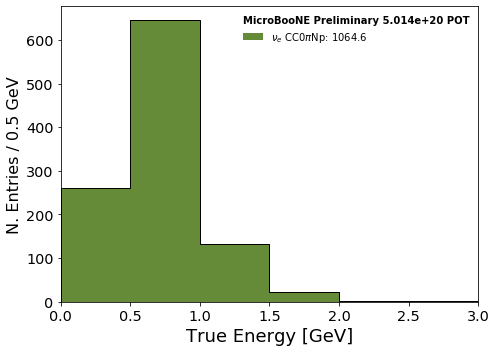

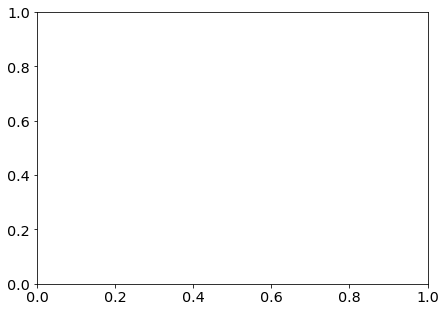

In [28]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_mc.shape[0]
print("n_events here = ", n_events)
print("")
#batch_size = 40000
batch_size = n_events

varss1 = []
weightss1 = []
labss1 = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_mc.iloc[start:end]

    samples = {
        #"nue_nue": nue_nue
        "numu_mc": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        mcratio   = pot/2.33978e+21
    elif isRun3 == True:
        pot =  5.014e20
        mcratio  = pot/1.98265e+21

    # NUMU
    weights = { #full sample mc = 0.38
                "numu_mc"  : mcratio  * SPLIT * scaling
    }


    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)


    #Now check on a variable
    #Remember to change the plotter keys between truth and mc
    
    VARIABLE, BINS, RANGE, XTIT = 'true_e',6,(0, 3),"True Energy [GeV]"


    var, weight, label = my_plotter.plot_variable(
        VARIABLE,
        query= SIGNAL_NUMU_SEL_QUERY,
        currentsample = "numu_mc",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    varss1.append(var)
    weightss1.append(weight)
    labss1.append(label)

No handles with labels found to put in legend.


(array([260.67164224, 644.45229507, 132.92911614,  23.37895337,
         1.65561367,   1.47569503]), array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. ]), <a list of 6 Patch objects>)
(array([0., 0., 0., 0., 0., 0.]), array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. ]), <a list of 6 Patch objects>)


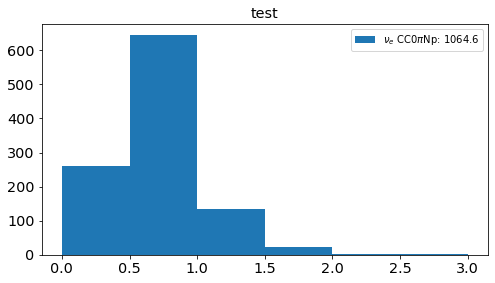

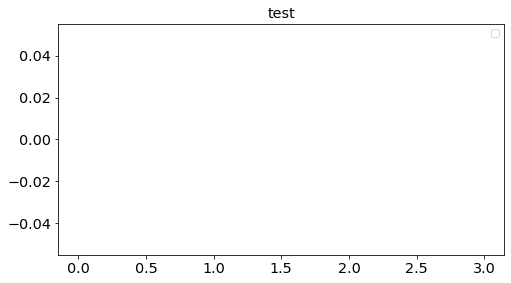

In [29]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
    numu_fig = plt.figure(figsize=(8, 7))
    numu_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    numu_ax1 = plt.subplot(numu_gs[0])
    #numu_ax1.set_xlim([0, 5])    #TrueE, lepton mom
    #nue_ax1.set_xlim([-1, 1])    #AngleDiff

    numu_stacked = numu_ax1.hist(
                varss1[i].values(),
                weights=list(weightss1[i].values()),
                stacked=True,
                label=labss1[i],
                bins=BINS,
                range=RANGE)
    
    plt.title("test")
    plt.legend()
    
    print(numu_stacked)
    #temp_truth_sig = nue_stacked[0]
    #print(temp_truth_sig)

[260.67164224 644.45229507 132.92911614  23.37895337   1.65561367
   1.47569503]


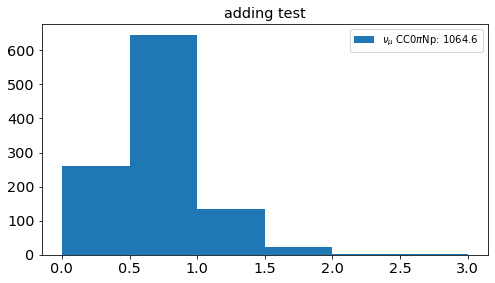

In [30]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    
varss_tot = combine_dicts(varss1)
weightss_tot = combine_dicts(weightss1)

category_labels = {
    1 : r'$\nu_\mu$ CC0$\pi$Np', 
    2 : r'Out FV',
    3 : r'$\nu_e$ CC $\pi^{0}$',
    4 : r'$\nu_e$ CC',
    5 : r'$\nu_e$ NC $\pi^{0}$',
    6 : r'$\nu_e$ NC',
    7 : r'$\bar{\nu}_\mu$ CC0$\pi$Np',
    8: r'$\nu_\mu$ NC',
    9: r'$\nu_\mu$ CC other',
    10 : r'$\nu_\mu$ / $\overline{\nu_\mu}$  other', 
    11 : r'$\nu_\mu$ / $\overline{\nu_e}$  $\pi^{0}$', 
    12 : r'$\nu_\mu$ / $\overline{\nu_e}$  other',
    0: r'Unknown'
}


labels = [
            "%s: %.1f" % (category_labels[c], sum(weightss_tot[0][c])) \
            if sum(weightss_tot[0][c]) else ""
            for c in varss1[0].keys()
        ]


numu_fig = plt.figure(figsize=(8, 7))
numu_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
numu_ax1 = plt.subplot(numu_gs[0])

#TrueE, LeptonMom
#numu_ax1.set_xlim([0, 5])
#nue_ax1.set_ylim([0, 160])
#nue_ax1.set_ylim([0, 40])

#AngleDiff
#nue_ax1.set_xlim([-1, 1])
#nue_ax1.set_ylim([0, 180])

numu_stacked = numu_ax1.hist(
            varss_tot[0].values(),
            weights=list(weightss_tot[0].values()),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)

plt.title("adding test")
plt.legend()

print(numu_stacked[0])

temp_truth_sig = numu_stacked[0]
#print('%.50f' % math.fsum(temp_truth_sig))

n_events here =  69023

1.0
1
{'numu_mc': 0.2528938541850554}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0 and contained_fraction> 0.95 and topological_score > 0.3and is_signal==True& reco_e <= 3 & reco_e >= 0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False 
 numu_mc
--------------------------------------
current_total  1064.5633155188211
1064.563315518821127625415101647377014160156250000000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------
current_total  1064.5633155188211
1064.5633155188211276254151016473770141601562500000000000000000000000000000000

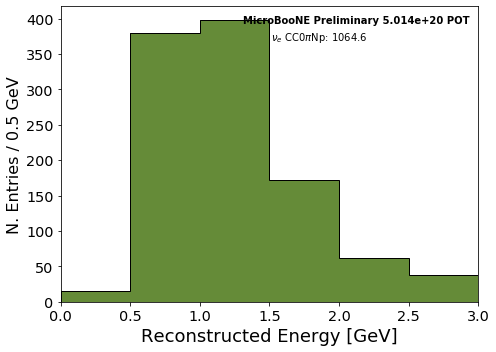

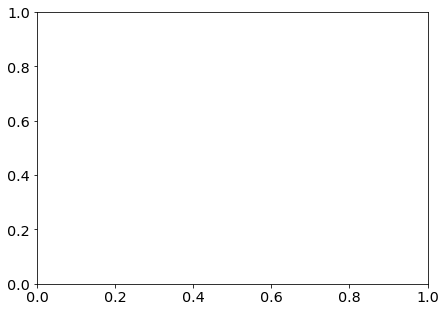

In [31]:
# NOW WITH RECO SELECTION

import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_mc.shape[0]
print("n_events here = ", n_events)
print("")
#batch_size = 40000
batch_size = n_events

varss2 = []
weightss2 = []
labss2 = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_mc.iloc[start:end]

    samples = {
        #"nue_nue": nue_nue
        "numu_mc": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        mcratio   = pot/2.33978e+21
    elif isRun3 == True:
        pot =  5.014e20
        mcratio  = pot/1.98265e+21

    # NUMU
    weights = { #full sample mc = 0.38
                "numu_mc"  : mcratio  * SPLIT * scaling
    }


    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)


    #Now check on a variable
    #Remember to change the plotter keys between truth and mc
    
    VARIABLE, BINS, RANGE, XTIT = 'reco_e',6,(0.0, 3),"Reconstructed Energy [GeV]"
    

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,
        query= SIGNAL_NUMU_SEL_QUERY,
        currentsample = "numu_mc",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    varss2.append(var)
    weightss2.append(weight)
    labss2.append(label)

No handles with labels found to put in legend.


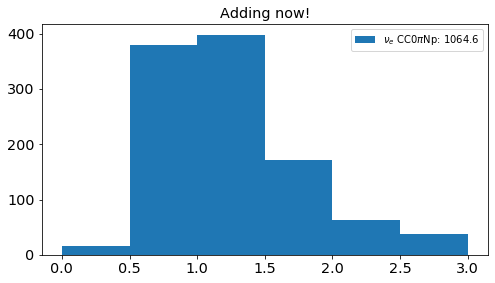

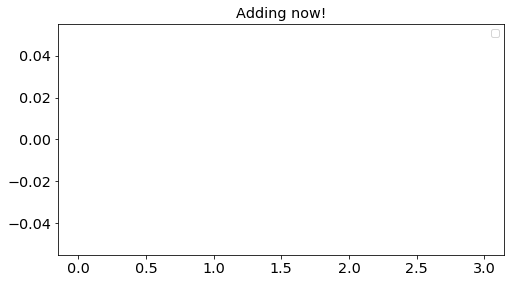

In [32]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
    numu_fig = plt.figure(figsize=(8, 7))
    numu_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    numu_ax1 = plt.subplot(numu_gs[0])
    #numu_ax1.set_xlim([0, 5])    #TrueE, lepton mom
    #nue_ax1.set_xlim([-1, 1])    #AngleDiff

    numu_stacked = numu_ax1.hist(
                varss2[i].values(),
                weights=list(weightss2[i].values()),
                stacked=True,
                label=labss2[i],
                bins=BINS,
                range=RANGE)
    
    plt.title("Adding now!")
    plt.legend()
    
    #print('%.50f' % math.fsum(numu_stacked[0]))

In [5]:
# plot the smearing matrix 
def plot_smearing(var1, var2, weight1, weight2, var3, weight3, bins, norm=False): 
    fig = plt.figure(figsize=(10, 6))
    
    smear = plt.hist2d(var1, var2,
                   bins, weights=weight1, cmin=0.000000001, cmap='OrRd')
    
    sel1 = plt.hist(var1, bins, weights=weight1, color='white')
    print("sel1 = ", sel1[0])
    print("sum sel1 = ", math.fsum(sel1[0]))
    print("")
    sel2 = plt.hist(var2, bins, weights=weight2, color='white')
    print("sel2 = ", sel2[0])
    print("sum sel2 = ", math.fsum(sel2[0]))
    print("")
    print("truth - reco (sel1 - sel2) ")
    print(sel1[0] - sel2[0])
    print(math.fsum(sel1[0]) - math.fsum(sel2[0]))
    
    zero_copy_smear = np.copy(smear[0].T)
    
    for i in range(len(bins)-1): # reco bins i (y axis) rows
        for j in range(len(bins)-1): # true bins j (x axis) cols
            if np.isnan(zero_copy_smear[i,j]):
                zero_copy_smear[i,j]= 0

    for i in range(len(bins)-1): # reco bins i (y axis) rows
        for j in range(len(bins)-1): # true bins j (x axis) cols
            if smear[0].T[i,j] > 0: 
                if smear[0].T[i,j]>80: 
                    col='white'
                else: 
                    col='black'
                    
                binx_centers = smear[1][j]+(smear[1][j+1]-smear[1][j])/2
                biny_centers = smear[2][i]+(smear[2][i+1]-smear[2][i])/2
                        
                plt.text(binx_centers, biny_centers, round(smear[0].T[i,j], 1), 
                    color=col, ha="center", va="center", fontsize=12)

    cbar = plt.colorbar()
    cbar.set_label('Selected Signal Events', fontsize=15)
        
    print("---------------------------------------------------------")

    if norm: 
        plt.close()
        
        norm_array = smear[0].T
        
        gen = plt.hist(var3, bins, weights=weight3, color='deepskyblue')
        print("")
        print("GENERATED")
        print(gen[0])
        print("")
        plt.close()
    
        # for each truth bin (column): 
        for j in range(len(bins)-1): 
        
            #reco_events_in_column = [ norm_array[i][j] for i in range(len(bins)-1) ]
            #tot_reco_events = np.nansum(reco_events_in_column)
        
            # replace with normalized value 
            for i in range(len(bins)-1):
                norm_array[i][j] =  norm_array[i][j] / gen[0][j]
    
        # now plot
        fig = plt.figure(figsize=(10, 6))
        plt.pcolor(bins, bins, norm_array, cmap='OrRd', vmax=1)
        
        zero_copy_smear_norm = np.copy(norm_array)

        for i in range(len(bins)-1): # reco bins i (y axis) rows
            for j in range(len(bins)-1): # true bins j (x axis) cols
                if np.isnan(zero_copy_smear_norm[i,j]):
                    zero_copy_smear_norm[i,j]= 0

        # Loop over data dimensions and create text annotations.
        for i in range(len(bins)-1): # reco bins (rows)
            for j in range(len(bins)-1): # truth bins (cols)
                if norm_array[i][j]>0: 
                
                    if norm_array[i][j]>0.7: 
                        col = 'white'
                    else: 
                        col = 'black'
                    
                    binx_centers = smear[1][j]+(smear[1][j+1]-smear[1][j])/2
                    biny_centers = smear[2][i]+(smear[2][i+1]-smear[2][i])/2
                
                    plt.text(binx_centers, biny_centers, round(norm_array[i][j], 2), 
                         ha="center", va="center", color=col, fontsize=12)
      
        cbar = plt.colorbar()
        cbar.set_label('Fraction of Reco Events in True Bin', fontsize=15)
        
        
        if isRun3 == False and isCombined == False:
            #WHOOPS, overwrote 3dp if needed again....
            np.savetxt("numu_full_500_catsel_nopions_recoE_usingSelection_smearcept_weighted_recoCut_"+ending+".csv", 
                zero_copy_smear_norm,
                delimiter =", ", 
                fmt ='% s')

            print("ZERO COPY SMEAR NORM")
            print(zero_copy_smear_norm)

            """
            with open('numu_full_500_catsel_nopions_recoE_usingSelection_prior_true_signal_recoCut_'+ending+'.csv') as file:
                content = file.readlines()
            prior_true = content[0:]

            for i in range(10):
                prior_true[i]=prior_true[i].rstrip().rstrip(',')
                prior_true[i] = float(prior_true[i])

            print("Prior Truth: ")
            print(prior_true)
            print('%.75f' % prior_true[2])
            print("")

            with open('numu_full_500_catsel_nopions_recoE_usingSelection_data_signal_MCONLY_recoCut_'+ending+'.csv') as file:
                content = file.readlines()
            mcsig = content[0:]

            for i in range(10):
                mcsig[i]=mcsig[i].rstrip().rstrip(',')
                mcsig[i] = float(mcsig[i])


            print("MC Signal: ")
            print(mcsig)
            print('%.75f' % mcsig[2])    
            print("")

            print("SMEAR x PRIOR_TRUE")
            made_data_sig = np.dot(zero_copy_smear_norm, prior_true)
            print(made_data_sig)
            print(sum(made_data_sig))
            print("")
            print("MC DATA SIGNAL")
            print(mcsig)
            print(sum(mcsig))
            print("")
            print("DIFFERENCES")
            diffs = made_data_sig - mcsig

            for i in range(10):
                print(diffs[i])
            """
            #print(diffs)
        elif isRun3 == True and isCombined == False:
            np.savetxt("numu_full_500_catsel_nopions_recoE_usingSelection_smearcept_weighted_recoCut_run3_"+ending+".csv", 
                zero_copy_smear_norm,
                delimiter =", ", 
                fmt ='% s')

            print("ZERO COPY SMEAR NORM")
            print(zero_copy_smear_norm)

            """
            with open('numu_full_500_catsel_nopions_recoE_usingSelection_prior_true_signal_recoCut_run3_'+ending+'.csv') as file:
                content = file.readlines()
            prior_true = content[0:]

            for i in range(10):
                prior_true[i]=prior_true[i].rstrip().rstrip(',')
                prior_true[i] = float(prior_true[i])

            print("Prior Truth: ")
            print(prior_true)
            print('%.75f' % prior_true[2])
            print("")

            with open('numu_full_500_catsel_nopions_recoE_usingSelection_data_signal_MCONLY_recoCut_run3_'+ending+'.csv') as file:
                content = file.readlines()
            mcsig = content[0:]

            for i in range(10):
                mcsig[i]=mcsig[i].rstrip().rstrip(',')
                mcsig[i] = float(mcsig[i])


            print("MC Signal: ")
            print(mcsig)
            print('%.75f' % mcsig[2])    
            print("")

            print("SMEAR x PRIOR_TRUE")
            made_data_sig = np.dot(zero_copy_smear_norm, prior_true)
            print(made_data_sig)
            print(sum(made_data_sig))
            print("")
            print("MC DATA SIGNAL")
            print(mcsig)
            print(sum(mcsig))
            print("")
            print("DIFFERENCES")
            diffs = made_data_sig - mcsig

            for i in range(10):
                print(diffs[i])
            """
            #print(diffs)
    
        elif isCombined == True:
            np.savetxt("numu_full_500_catsel_nopions_recoE_usingSelection_smearcept_weighted_recoCut_comb_"+ending+".csv", 
                zero_copy_smear_norm,
                delimiter =", ", 
                fmt ='% s')

            print("ZERO COPY SMEAR NORM")
            print(zero_copy_smear_norm)

            """
            with open('numu_full_500_catsel_nopions_recoE_usingSelection_prior_true_signal_recoCut_comb_'+ending+'.csv') as file:
                content = file.readlines()
            prior_true = content[0:]

            for i in range(10):
                prior_true[i]=prior_true[i].rstrip().rstrip(',')
                prior_true[i] = float(prior_true[i])

            print("Prior Truth: ")
            print(prior_true)
            print('%.75f' % prior_true[2])
            print("")

            with open('numu_full_500_catsel_nopions_recoE_usingSelection_data_signal_MCONLY_recoCut_comb_'+ending+'.csv') as file:
                content = file.readlines()
            mcsig = content[0:]

            for i in range(10):
                mcsig[i]=mcsig[i].rstrip().rstrip(',')
                mcsig[i] = float(mcsig[i])


            print("MC Signal: ")
            print(mcsig)
            print('%.75f' % mcsig[2])    
            print("")

            print("SMEAR x PRIOR_TRUE")
            made_data_sig = np.dot(zero_copy_smear_norm, prior_true)
            print(made_data_sig)
            print(sum(made_data_sig))
            print("")
            print("MC DATA SIGNAL")
            print(mcsig)
            print(sum(mcsig))
            print("")
            print("DIFFERENCES")
            diffs = made_data_sig - mcsig

            for i in range(10):
                print(diffs[i])
            """
        
    plt.xlabel('True ν Energy [GeV]', fontsize=15)
    plt.ylabel('Reco ν Energy [GeV]', fontsize=15)
    plt.text(0.1, 4.8, r'MicroBooNE In Progress', fontweight='bold')
    
    plt.show()
    fig.savefig("numu_full_500_catsel_nopions_recoE_usingSelection_smearcept_weighted_recoCut_comb_"+ending+".svg",bbox_inches='tight' )
    
    if norm:
        return zero_copy_smear_norm
    else:
        return zero_copy_smear

In [6]:
def _selection(variable, sample, query="selected==1", extra_cut=None, track_cuts=None, select_longest=True):
        '''
        variable,  must be specified
        select_longest, True by default, keeps from multiple tracks of same event making it through
        query must be a string defining event-level cuts
        track_cuts is a list of cuts of which each entry looks like
            (variable_tobe_cut_on, '>'or'<'or'=='etc, cut value )
            or
            (variable, [operator1, operator2], [cutval1, cutval2]) to do an 'or' cut
        track_
        returns an Series of values that pass all track_cuts
        '''
        sel_query = query
        if extra_cut is not None:
            sel_query += "& %s" % extra_cut
        '''
        if ( (track_cuts == None) or (select_longest == False) ):
            return sample.query(sel_query).eval(variable).ravel()
        '''


        '''
        df = sample.query(sel_query)
        #print (df.isna().sum())
        dfna = df.isna()
        for (colname,colvals) in dfna.iteritems():
            if (colvals.sum() != 0):
                print ('name : ',colname)
                print ('nan entries : ',colvals.sum())
        '''  
        df = sample.query(sel_query)
        
        #if (track_cuts != None):
        #    df = sample.query(sel_query).dropna().copy() #don't want to eliminate anything from memory

        #df = sample.query(sel_query).dropna().copy() #don't want to eliminate anything from memory

        track_cuts_mask = None #df['trk_score_v'].apply(lambda x: x == x) #all-True mask, assuming trk_score_v is available
        if track_cuts is not None:
            vars, track_cuts_mask = _apply_track_cuts(df,variable,track_cuts,track_cuts_mask)
        else:
            vars = df[variable]
        #vars is now a Series object that passes all the cuts
        #select longest of the cut passing tracks
        #assuming all track-level variables end in _v
        if variable[-2:] == "_v" and select_longest:
            vars, longest_mask = _select_longest(df, vars, track_cuts_mask)
        elif "_v_" in variable:
            print("Variable is being interpretted as event-level, not track_level, despite having _v in name")
            print("the longest track is NOT being selected")
        return vars.ravel()
    
#-------------------------------------------------------------------
def _apply_track_cuts(df,variable,track_cuts,mask):
    '''
    df is dataframe of the sample of interest
    variable is what values will be in the output
    track_cuts are list of tuples defining track_cuts
    input mask to be built upon

    returns
        Series of values of variable that pass all track_cuts
        boolean mask that represents union of input mask and new cut mask
    '''
    #need to do this fancy business with the apply function to make masks
    #this is because unflattened DataFrames are used
    for (var,op,val) in track_cuts:
        if type(op) == list:
            #this means treat two conditions in an 'or' fashion
            or_mask1 = df[var].apply(lambda x: eval("x{}{}".format(op[0],val[0])))#or condition 1
            or_mask2 = df[var].apply(lambda x: eval("x{}{}".format(op[1],val[1])))#or condition 2
            mask *= (or_mask1 + or_mask2) #just add the booleans for "or"
        else:
            mask *= df[var].apply(lambda x: eval("x{}{}".format(op,val))) #layer on each cut mask
    vars = (df[variable]*mask).apply(lambda x: x[x != False]) #apply mask
    vars = vars[vars.apply(lambda x: len(x) > 0)] #clean up empty slices
    #fix list comprehension issue for non '_v' variables
    if variable[-2:] != "_v":
        vars = vars.apply(lambda x: x[0])
    elif "_v" not in variable:
        print("_v not found in variable, assuming event-level")
        print("not fixing list comprehension bug for this variable")

    return vars, mask
    
#-----------------------------------------------------------------------

def _select_longest(df, variable, mask):
    '''
    df: dataframe for sample
    variable: Series of values that pass cuts defined by mask
    mask: mask used to find variable

    returns
        list of values of variable corresponding to longest track in each slices
        boolean mask for longest tracks in df
    '''

    #print("selecting longest...")
    #print("mask", mask)
    trk_lens = (df['trk_len_v']*mask).apply(lambda x: x[x != False])#apply mask to track lengths
    trk_lens = trk_lens[trk_lens.apply(lambda x: len(x) > 0)]#clean up slices
    variable = variable.apply(lambda x: x[~np.isnan(x)])#clean up nan vals
    variable = variable[variable.apply(lambda x: len(x) > 0)] #clean up empty slices
    nan_mask = variable.apply(lambda x: np.nan in x or "nan" in x)
    longest_mask = trk_lens.apply(lambda x: x == x[list(x).index(max(x))])#identify longest
    variable = (variable*longest_mask).apply(lambda x: x[x!=False])#apply mask
    if len(variable.iloc[0]) == 1:
        variable = variable.apply(lambda x: x[0] if len(x)>0 else -999)#expect values, not lists, for each event
    else:
        if len(variable.iloc[0]) == 0:
            raise ValueError(
                "There is no longest track per slice")
        elif len(variable.iloc[0]) > 1:
            #this happens with the reco_nu_e_range_v with unreconstructed values
            print("there are more than one longest slice")
            print(variable.iloc[0])
            try:
                variable = variable.apply(lambda x: x[0])
            except:
                raise ValueError(
                    "There is more than one longest track per slice in \n var {} lens {}".format(variable,trk_lens))

    return variable, longest_mask
    
#-----------------------------------------------------------------------
def _get_genie_weight(sample, variable, query="selected==1", extra_cut=None, track_cuts=None,\
                          select_longest=True, weightvar="weightSplineTimesTuneTimesPPFX",weightsignal=None):

        plotted_variable = _selection(
            variable, sample, query=query, extra_cut=extra_cut, track_cuts=track_cuts, select_longest=select_longest)
        genie_weights = _selection(
            weightvar, sample, query=query, extra_cut=extra_cut, track_cuts=track_cuts, select_longest=select_longest)
        if (weightsignal != None):
            genie_weights *= _selection(
            weightsignal, sample, query=query, extra_cut=extra_cut, track_cuts=track_cuts, select_longest=select_longest)
        if plotted_variable.size > 0:
            if isinstance(plotted_variable[0], np.ndarray):
                if "trk" in variable or select_longest:
                    score = self._selection(
                        "trk_score_v", sample, query=query, extra_cut=extra_cut, track_cuts=track_cuts, select_longest=select_longest)
                else:
                    score = self._selection(
                        "shr_score_v", sample, query=query, extra_cut=extra_cut, track_cuts=track_cuts, select_longest=select_longest)
                genie_weights = np.array([
                    np.array([c] * len(v[s > 0.5])) for c, v, s in zip(genie_weights, plotted_variable, score)
                ])
                genie_weights = np.hstack(genie_weights)
        return genie_weights
    

n_events here =  69023
n_events/2 here =  34511.0

1.0
1
All is well.
sel1 =  [260.67175293 644.45263672 132.92883301  23.37902832   1.65563965
   1.47570801]
sum sel1 =  1064.5635986328125

sel2 =  [ 15.09400749 380.04074097 397.22592163 172.05895996  62.11749268
  38.02587891]
sum sel2 =  1064.5630016326904

truth - reco (sel1 - sel2) 
[ 245.57774544  264.41189575 -264.29708862 -148.67993164  -60.46185303
  -36.5501709 ]
0.0005970001220703125
---------------------------------------------------------

GENERATED
[3476.75708008 6881.03320312 3999.82617188 1805.84472656  956.78125
 2079.6328125 ]

ZERO COPY SMEAR NORM
[[4.00939661e-03 1.34093958e-04 5.79040478e-05 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [6.61509578e-02 2.07310467e-02 1.41598500e-03 4.71385140e-04
  5.24040190e-04 1.83955891e-04]
 [4.77932862e-03 5.29182835e-02 3.74331170e-03 6.24445395e-04
  2.50931937e-04 6.59759927e-05]
 [3.58323005e-05 1.90459114e-02 9.55165431e-03 1.21424076e-03
  3.63616530e-04 6.39898545e-

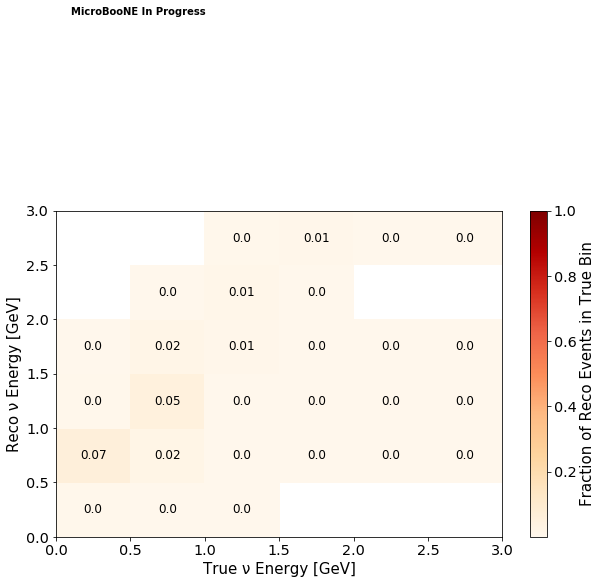

In [35]:
n_events = numu_mc.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("")
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))


start = 0*batch_size
if (start + batch_size) < n_events:
    end = start + batch_size
else:
    end = n_events
sample_set = numu_mc.iloc[start:end]


scaling = 1
if isRun3 == False:
    pot =  2e+20 
    mcratio   = pot/2.33978e+21
elif isRun3 == True:
    pot =  5.014e20
    mcratio  = pot/1.98265e+21

# NUMU
weights = { #full sample mc = 0.38
            "numu_mc"  : mcratio  * SPLIT * scaling
}

current_genie_weights = _get_genie_weight(
                sample_set, 'true_e', query=SIGNAL_NUMU_SEL_QUERY, track_cuts=None,select_longest=False, weightvar="weightSplineTimesTuneTimesPPFX")


current_genie_weights2 = _get_genie_weight(
                sample_set, 'reco_e', query=SIGNAL_NUMU_SEL_QUERY, track_cuts=None,select_longest=False, weightvar="weightSplineTimesTuneTimesPPFX")


current_genie_weights3 = _get_genie_weight(
                sample_set, 'true_e', query=SIGNAL_ONLY_NUMU_SEL_QUERY, track_cuts=None,select_longest=False, weightvar="weightSplineTimesTuneTimesPPFX")

test_list1 = current_genie_weights
test_list2 = current_genie_weights2

if len(test_list1) == len(test_list2) and len(test_list1) == sum([1 for i, j in zip(test_list1, test_list2) if i == j]):
    print("All is well.")
else:
    print("Oh no.")

bins = np.arange(0.0, 3.5, 0.5)


#Need to save these inputs for R1 and R3, then combine later
var1 = sample_set.query(SIGNAL_NUMU_SEL_QUERY)['true_e']
weight1 = current_genie_weights * weights["numu_mc"]
if isRun3 == False and isCombined == False:
    var1.to_csv("numu_full_var1_recoCut_"+ending+".csv")
    np.savetxt("numu_full_weight1_recoCut_"+ending+".csv", 
                weight1,
                delimiter =", ", 
                fmt ='% s')
if isRun3 == True and isCombined == False:
    var1.to_csv("numu_full_var1_recoCut_run3_"+ending+".csv")
    np.savetxt("numu_full_weights1_recoCut_run3_"+ending+".csv", 
                weight1,
                delimiter =", ", 
                fmt ='% s')     

var2 = sample_set.query(SIGNAL_NUMU_SEL_QUERY)['reco_e']
weight2 = current_genie_weights2* weights["numu_mc"]
if isRun3 == False and isCombined == False:
    var2.to_csv("numu_full_var2_recoCut_"+ending+".csv")
    np.savetxt("numu_full_weight2_recoCut_"+ending+".csv", 
                weight2,
                delimiter =", ", 
                fmt ='% s')
if isRun3 == True and isCombined == False:
    var2.to_csv("numu_full_var2_recoCut_run3_"+ending+".csv")
    np.savetxt("numu_full_weights2_recoCut_run3_"+ending+".csv", 
                weight2,
                delimiter =", ", 
                fmt ='% s')

var3 = sample_set.query(SIGNAL_ONLY_NUMU_SEL_QUERY)['true_e']
weight3 = current_genie_weights3* weights["numu_mc"]
if isRun3 == False and isCombined == False:
    var3.to_csv("numu_full_var3_recoCut_"+ending+".csv")
    np.savetxt("numu_full_weight3_recoCut_"+ending+".csv", 
                weight3,
                delimiter =", ", 
                fmt ='% s')
if isRun3 == True and isCombined == False:
    var3.to_csv("numu_full_var3_recoCut_run3_"+ending+".csv")
    np.savetxt("numu_full_weights3_recoCut_run3_"+ending+".csv", 
                weight3,
                delimiter =", ", 
                fmt ='% s')


zerocopysmear = plot_smearing(var1, var2, weight1, weight2, var3, weight3, bins, norm=True)

### Now look at Efficiency and Purity

In [7]:
# from Katerina  - modified, to be able to plot truth mc with nue eff selections
# plot efficiency overlaid on selected signal events 
def plot_signal_and_eff(var1, weight1, var2, weight2, bins, variable, xaxis, savetitle, savetitleplot): 
    
    # generated true signal events per bin 
    gen = plt.hist(var1, bins, weights=weight1, color='deepskyblue')
    plt.close()
    
    # plot selected signal events 
    fig, ax1 = plt.subplots(figsize=(4, 5))
    
    # compute efficiency
    sel = ax1.hist(var2, bins, weights=weight2, color='white')
    print("sel = ", sel[0])
    print("")
    print("gen = ", gen[0])
    eff = [ a/b for a, b in zip(sel[0], gen[0]) ]
    eff_err = []
    for i in range(len(eff)):
        eff_err.append(math.sqrt( (eff[i]*(1-eff[i]))/gen[0][i] ) )
        print("In bin", i, ", eff = ", eff[i], " with error = ", eff_err[i])
        
    eff_tot = sum(sel[0])/sum(gen[0])
    print("Total Eff")
    print(eff_tot)
        
    # compute bin centers 
    bc = 0.5*(sel[1][1:]+sel[1][:-1])
    x_err = []
    for i in range(len(sel[1])-1): 
        x_err.append((sel[1][i+1]-sel[1][i])/2)

    # plot efficiency
    ax1.errorbar(bc, eff, xerr=x_err, yerr=eff_err, fmt='o', color='orangered', ecolor='orangered', markersize=3) 
    ax1.set_ylim(0, 1)
    ax1.set_ylabel('Efficiency', fontsize=15)
    ax1.set_title("Efficiency")
    #ax1.set_ylabel('Purity', fontsize=15)
    #ax1.set_title("Purity")
    ax1.set_xlabel(xaxis)
    
    np.savetxt(savetitle,
           eff,
           delimiter =", ", 
           fmt ='% s')
    
    print("Plot title: ", savetitleplot)
    fig.savefig(savetitleplot,bbox_inches='tight' )

    plt.show()

In [37]:
#ENERGY
# Efficiency =  tot_sig_sel/tot_sig
#-----------------------------------------------------------------------------------
##SEL_QUERY + fidq = TOTAL_QUERY
bins = np.arange(0.0, 3.5, 0.5)
scaling = 1
SPLIT = 1.0

if isRun3 == False:
    pot =  2e+20 
    mcratio   = pot/2.33978e+21
elif isRun3 == True:
    pot =  5.014e20
    mcratio  = pot/1.98265e+21

# NUMU
weights = { #full sample mc = 0.38
            "numu_mc"  : mcratio  * SPLIT * scaling
}

current_genie_weights = _get_genie_weight(
                numu_mc, 'true_e', query=SIGNAL_ONLY_NUMU_SEL_QUERY, track_cuts=None,select_longest=False, weightvar="weightSplineTimesTuneTimesPPFX")

current_genie_weights2 = _get_genie_weight(
                numu_mc, 'true_e', query=SIGNAL_NUMU_SEL_QUERY, track_cuts=None,select_longest=False, weightvar="weightSplineTimesTuneTimesPPFX")


var1 = numu_mc.query(SIGNAL_ONLY_NUMU_SEL_QUERY)['true_e']
weight1 = current_genie_weights* weights["numu_mc"]
if isRun3 == False and isCombined == False:
    var1.to_csv("numu_full_var1_eff_recoCut_"+ending+".csv")
    np.savetxt("numu_full_weight1_eff_recoCut_"+ending+".csv", 
                weight1,
                delimiter =", ", 
                fmt ='% s')
if isRun3 == True and isCombined == False:
    var1.to_csv("numu_full_var1_eff_recoCut_run3_"+ending+".csv")
    np.savetxt("numu_full_weights1_eff_recoCut_run3_"+ending+".csv", 
                weight1,
                delimiter =", ", 
                fmt ='% s') 

var2 = numu_mc.query(SIGNAL_NUMU_SEL_QUERY)['true_e']
weight2 = current_genie_weights2 * weights["numu_mc"]
if isRun3 == False and isCombined == False:
    var2.to_csv("numu_full_var2_eff_recoCut_"+ending+".csv")
    np.savetxt("numu_full_weight2_eff_recoCut_"+ending+".csv", 
                weight2,
                delimiter =", ", 
                fmt ='% s')
if isRun3 == True and isCombined == False:
    var2.to_csv("numu_full_var2_eff_recoCut_run3_"+ending+".csv")
    np.savetxt("numu_full_weights2_eff_recoCut_run3_"+ending+".csv", 
                weight2,
                delimiter =", ", 
                fmt ='% s')


###########################################

variable = 'true_e'
xaxis = "True Neutrino Energy [GeV]"
if isRun3 == False and isCombined == False:
    savetitle = "batch_eff_numu_fig_full_500_catsel_nopions_recoE_matrix_trueeff_"+ending+".csv"
if isRun3 == True and isCombined == False:
    savetitle = "batch_eff_numu_fig_full_500_catsel_nopions_recoE_matrix_trueeff_run3_"+ending+".csv"

#plot_signal_and_eff(var1, weight1, var2, weight2, bins, variable, xaxis, savetitle)

### Combined Loading and Calculation

In [8]:
# plot the smearing matrix 
def plot_smearing(var1, var2, weight1, weight2, var3, weight3, bins, norm=False): 
    fig = plt.figure(figsize=(10, 6))
    
    smear = plt.hist2d(var1, var2,
                   bins, weights=weight1, cmin=0.000000001, cmap='OrRd')
    
    sel1 = plt.hist(var1, bins, weights=weight1, color='white')
    print("sel1 = ", sel1[0])
    print("sum sel1 = ", math.fsum(sel1[0]))
    print("")
    sel2 = plt.hist(var2, bins, weights=weight2, color='white')
    print("sel2 = ", sel2[0])
    print("sum sel2 = ", math.fsum(sel2[0]))
    print("")
    print("truth - reco (sel1 - sel2) ")
    print(sel1[0] - sel2[0])
    print(math.fsum(sel1[0]) - math.fsum(sel2[0]))
    
    zero_copy_smear = np.copy(smear[0].T)
    
    for i in range(len(bins)-1): # reco bins i (y axis) rows
        for j in range(len(bins)-1): # true bins j (x axis) cols
            if np.isnan(zero_copy_smear[i,j]):
                zero_copy_smear[i,j]= 0

    for i in range(len(bins)-1): # reco bins i (y axis) rows
        for j in range(len(bins)-1): # true bins j (x axis) cols
            if smear[0].T[i,j] > 0: 
                if smear[0].T[i,j]>80: 
                    col='white'
                else: 
                    col='black'
                    
                binx_centers = smear[1][j]+(smear[1][j+1]-smear[1][j])/2
                biny_centers = smear[2][i]+(smear[2][i+1]-smear[2][i])/2
                        
                plt.text(binx_centers, biny_centers, round(smear[0].T[i,j], 1), 
                    color=col, ha="center", va="center", fontsize=12)

    cbar = plt.colorbar()
    cbar.set_label('Selected Signal Events', fontsize=15)
        
    print("---------------------------------------------------------")

    if norm: 
        plt.close()
        
        norm_array = smear[0].T
        
        gen = plt.hist(var3, bins, weights=weight3, color='deepskyblue')
        print("")
        print("GENERATED")
        print(gen[0])
        print("")
        plt.close()
    
        # for each truth bin (column): 
        for j in range(len(bins)-1): 
        
            #reco_events_in_column = [ norm_array[i][j] for i in range(len(bins)-1) ]
            #tot_reco_events = np.nansum(reco_events_in_column)
        
            # replace with normalized value 
            for i in range(len(bins)-1):
                norm_array[i][j] =  norm_array[i][j] / gen[0][j]
    
        # now plot
        fig = plt.figure(figsize=(10, 6))
        plt.pcolor(bins, bins, norm_array, cmap='OrRd', vmax=1)
        
        zero_copy_smear_norm = np.copy(norm_array)

        for i in range(len(bins)-1): # reco bins i (y axis) rows
            for j in range(len(bins)-1): # true bins j (x axis) cols
                if np.isnan(zero_copy_smear_norm[i,j]):
                    zero_copy_smear_norm[i,j]= 0

        # Loop over data dimensions and create text annotations.
        for i in range(len(bins)-1): # reco bins (rows)
            for j in range(len(bins)-1): # truth bins (cols)
                if norm_array[i][j]>0: 
                
                    if norm_array[i][j]>0.7: 
                        col = 'white'
                    else: 
                        col = 'black'
                    
                    binx_centers = smear[1][j]+(smear[1][j+1]-smear[1][j])/2
                    biny_centers = smear[2][i]+(smear[2][i+1]-smear[2][i])/2
                
                    plt.text(binx_centers, biny_centers, round(norm_array[i][j], 2), 
                         ha="center", va="center", color=col, fontsize=12)
      
        cbar = plt.colorbar()
        cbar.set_label('Fraction of Reco Events in True Bin', fontsize=15)
        
        
        if isRun3 == False and isCombined == False:
            #WHOOPS, overwrote 3dp if needed again....
            np.savetxt("numu_full_500_catsel_nopions_recoE_usingSelection_smearcept_weighted_recoCut_"+ending+".csv", 
                zero_copy_smear_norm,
                delimiter =", ", 
                fmt ='% s')

            print("ZERO COPY SMEAR NORM")
            print(zero_copy_smear_norm)

            """
            with open('numu_full_500_catsel_nopions_recoE_usingSelection_prior_true_signal_recoCut_'+ending+'.csv') as file:
                content = file.readlines()
            prior_true = content[0:]

            for i in range(10):
                prior_true[i]=prior_true[i].rstrip().rstrip(',')
                prior_true[i] = float(prior_true[i])

            print("Prior Truth: ")
            print(prior_true)
            print('%.75f' % prior_true[2])
            print("")

            with open('numu_full_500_catsel_nopions_recoE_usingSelection_data_signal_MCONLY_recoCut_'+ending+'.csv') as file:
                content = file.readlines()
            mcsig = content[0:]

            for i in range(10):
                mcsig[i]=mcsig[i].rstrip().rstrip(',')
                mcsig[i] = float(mcsig[i])


            print("MC Signal: ")
            print(mcsig)
            print('%.75f' % mcsig[2])    
            print("")

            print("SMEAR x PRIOR_TRUE")
            made_data_sig = np.dot(zero_copy_smear_norm, prior_true)
            print(made_data_sig)
            print(sum(made_data_sig))
            print("")
            print("MC DATA SIGNAL")
            print(mcsig)
            print(sum(mcsig))
            print("")
            print("DIFFERENCES")
            diffs = made_data_sig - mcsig

            for i in range(10):
                print(diffs[i])
            """
            #print(diffs)
        elif isRun3 == True and isCombined == False:
            np.savetxt("numu_full_500_catsel_nopions_recoE_usingSelection_smearcept_weighted_recoCut_run3_"+ending+".csv", 
                zero_copy_smear_norm,
                delimiter =", ", 
                fmt ='% s')

            print("ZERO COPY SMEAR NORM")
            print(zero_copy_smear_norm)

            """
            with open('numu_full_500_catsel_nopions_recoE_usingSelection_prior_true_signal_recoCut_run3_'+ending+'.csv') as file:
                content = file.readlines()
            prior_true = content[0:]

            for i in range(10):
                prior_true[i]=prior_true[i].rstrip().rstrip(',')
                prior_true[i] = float(prior_true[i])

            print("Prior Truth: ")
            print(prior_true)
            print('%.75f' % prior_true[2])
            print("")

            with open('numu_full_500_catsel_nopions_recoE_usingSelection_data_signal_MCONLY_recoCut_run3_'+ending+'.csv') as file:
                content = file.readlines()
            mcsig = content[0:]

            for i in range(10):
                mcsig[i]=mcsig[i].rstrip().rstrip(',')
                mcsig[i] = float(mcsig[i])


            print("MC Signal: ")
            print(mcsig)
            print('%.75f' % mcsig[2])    
            print("")

            print("SMEAR x PRIOR_TRUE")
            made_data_sig = np.dot(zero_copy_smear_norm, prior_true)
            print(made_data_sig)
            print(sum(made_data_sig))
            print("")
            print("MC DATA SIGNAL")
            print(mcsig)
            print(sum(mcsig))
            print("")
            print("DIFFERENCES")
            diffs = made_data_sig - mcsig

            for i in range(10):
                print(diffs[i])
            """
            #print(diffs)
    
        elif isCombined == True:
            np.savetxt("numu_full_500_catsel_nopions_recoE_usingSelection_smearcept_weighted_recoCut_comb_"+ending+".csv", 
                zero_copy_smear_norm,
                delimiter =", ", 
                fmt ='% s')

            print("ZERO COPY SMEAR NORM")
            print(zero_copy_smear_norm)

            """
            with open('numu_full_500_catsel_nopions_recoE_usingSelection_prior_true_signal_recoCut_comb_'+ending+'.csv') as file:
                content = file.readlines()
            prior_true = content[0:]

            for i in range(8):
                prior_true[i]=prior_true[i].rstrip().rstrip(',')
                prior_true[i] = float(prior_true[i])

            print("Prior Truth: ")
            print(prior_true)
            print('%.75f' % prior_true[2])
            print("")

            with open('numu_full_500_catsel_nopions_recoE_usingSelection_data_signal_MCONLY_recoCut_comb_'+ending+'.csv') as file:
                content = file.readlines()
            mcsig = content[0:]

            for i in range(8):
                mcsig[i]=mcsig[i].rstrip().rstrip(',')
                mcsig[i] = float(mcsig[i])


            print("MC Signal: ")
            print(mcsig)
            print('%.75f' % mcsig[2])    
            print("")

            print("SMEAR x PRIOR_TRUE")
            made_data_sig = np.dot(zero_copy_smear_norm, prior_true)
            print(made_data_sig)
            print(sum(made_data_sig))
            print("")
            print("MC DATA SIGNAL")
            print(mcsig)
            print(sum(mcsig))
            print("")
            print("DIFFERENCES")
            diffs = made_data_sig - mcsig

            for i in range(8):
                print(diffs[i])
            """
        
    plt.xlabel('True ν Energy [GeV]', fontsize=15)
    plt.ylabel('Reco ν Energy [GeV]', fontsize=15)
    plt.text(0.1, 1.8, r'MicroBooNE In Progress', fontweight='bold')
    
    plt.show()
    fig.savefig("numu_full_500_catsel_nopions_recoE_usingSelection_smearcept_weighted_recoCut_comb_"+ending+".svg",bbox_inches='tight' )
    
    if norm:
        return zero_copy_smear_norm
    else:
        return zero_copy_smear

<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
sel1 =  [385.21261766 891.01735832 192.82728351  37.14778005   2.97024896
   1.83459806]
sum sel1 =  1511.0098865590319

sel2 =  [ 22.82507207 550.18098349 547.82546185 242.73678077  87.59627814
  59.84531023]
sum sel2 =  1511.0098865590312

truth - reco (sel1 - sel2) 
[ 362.38754559  340.83637483 -354.99817834 -205.58900072  -84.62602918
  -58.01071217]
6.821210263296962e-13
---------------------------------------------------------

GENERATED
[5549.84169702 9509.79952903 5858.91608226 2824.28006742 1350.01656544
 2513.9434064 ]

ZERO COPY SMEAR NORM
[[3.90475299e-03 9.70267541e-05 3.95305423e-05 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [6.17981100e-02 2.08810185e-02 1.11589066e-03 3.93339670e-04
  3.71396798e-04 1.93621316e-04]
 [3.62950070e-03 5.29261589e-02 3.65614289e-03 8.37311215e-04
  2.62978410e-04 8.92166922e-05]
 [6.76228764e-05 1.89842423e-02 9.82943906e-03 1.29593768e-03
  2.78315103e-04 7.93441744e-05]
 [9

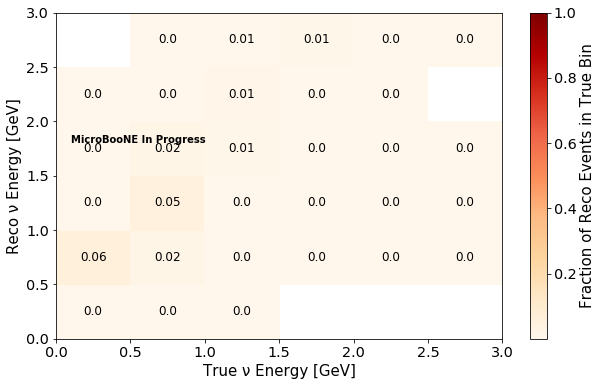

In [9]:
#####Smearing####
smearing_var1_run1 = pd.read_csv("numu_full_var1_recoCut_"+ending+".csv")

with open('numu_full_weight1_recoCut_'+ending+'.csv', 'r') as read_obj:
        csv_reader = csv.reader(read_obj)
        smearing_weight1_run1 = list(csv_reader)

for a in range(len(smearing_weight1_run1)):
    smearing_weight1_run1[a] = float(smearing_weight1_run1[a][0])
### 
smearing_var2_run1 = pd.read_csv("numu_full_var2_recoCut_"+ending+".csv")

with open('numu_full_weight2_recoCut_'+ending+'.csv', 'r') as read_obj:
        csv_reader = csv.reader(read_obj)
        smearing_weight2_run1 = list(csv_reader)

for a in range(len(smearing_weight2_run1)):
    smearing_weight2_run1[a] = float(smearing_weight2_run1[a][0])
### 
smearing_var3_run1 = pd.read_csv("numu_full_var3_recoCut_"+ending+".csv")

with open('numu_full_weight3_recoCut_'+ending+'.csv', 'r') as read_obj:
        csv_reader = csv.reader(read_obj)
        smearing_weight3_run1 = list(csv_reader)

for a in range(len(smearing_weight3_run1)):
    smearing_weight3_run1[a] = float(smearing_weight3_run1[a][0])
###---####
smearing_var1_run3 = pd.read_csv("numu_full_var1_recoCut_run3_"+ending+".csv")

with open('numu_full_weights1_recoCut_run3_'+ending+'.csv', 'r') as read_obj:
        csv_reader = csv.reader(read_obj)
        smearing_weight1_run3 = list(csv_reader)

for a in range(len(smearing_weight1_run3)):
    smearing_weight1_run3[a] = float(smearing_weight1_run3[a][0])
### 
smearing_var2_run3 = pd.read_csv("numu_full_var2_recoCut_run3_"+ending+".csv")

with open('numu_full_weights2_recoCut_run3_'+ending+'.csv', 'r') as read_obj:
        csv_reader = csv.reader(read_obj)
        smearing_weight2_run3 = list(csv_reader)

for a in range(len(smearing_weight2_run3)):
    smearing_weight2_run3[a] = float(smearing_weight2_run3[a][0])
### 
smearing_var3_run3 = pd.read_csv("numu_full_var3_recoCut_run3_"+ending+".csv")

with open('numu_full_weights3_recoCut_run3_'+ending+'.csv', 'r') as read_obj:
        csv_reader = csv.reader(read_obj)
        smearing_weight3_run3 = list(csv_reader)

for a in range(len(smearing_weight3_run3)):
    smearing_weight3_run3[a] = float(smearing_weight3_run3[a][0])
    
####################Add#####################

var_temps = [smearing_var1_run1, smearing_var1_run3]
var1 = pd.concat(var_temps)
var1 = var1.drop(["entry"], axis=1)
var1 = var1.squeeze()
weight1 = list(smearing_weight1_run1) + list(smearing_weight1_run3)
weight1 = np.array(weight1)

print(type(var1))
print(type(weight1))

var_temps = [smearing_var2_run1, smearing_var2_run3]
var2 = pd.concat(var_temps)
var2 = var2.drop(["entry"], axis=1)
var2 = var2.squeeze()
weight2 = list(smearing_weight2_run1) + list(smearing_weight2_run3)
weight2 = np.array(weight2)

var_temps = [smearing_var3_run1, smearing_var3_run3]
var3 = pd.concat(var_temps)
var3 = var3.drop(["entry"], axis=1)
var3 = var3.squeeze()
weight3 = list(smearing_weight3_run1) + list(smearing_weight3_run3)
weight3 = np.array(weight3)

bins = np.arange(0.0, 3.5, 0.5)

zerocopysmear = plot_smearing(var1, var2, weight1, weight2, var3, weight3, bins, norm=True)

<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
sel =  [385.21261766 891.01735832 192.82728351  37.14778005   2.97024896
   1.83459806]

gen =  [5549.84169702 9509.79952903 5858.91608226 2824.28006742 1350.01656544
 2513.9434064 ]
In bin 0 , eff =  0.06940965863386878  with error =  0.003411527895661729
In bin 1 , eff =  0.09369465209007999  with error =  0.0029881953929370847
In bin 2 , eff =  0.032911767433777356  with error =  0.002330773187026137
In bin 3 , eff =  0.013153008612008542  with error =  0.0021437966229552125
In bin 4 , eff =  0.0022001574144607165  with error =  0.0012752021725200577
In bin 5 , eff =  0.0007297690370941329  with error =  0.0005385877148837399
Total Eff
0.05473325527533939
Plot title:  batch_eff_numu_fig_full_500_catsel_nopions_recoE_matrix_trueeff_Jan19b.svg


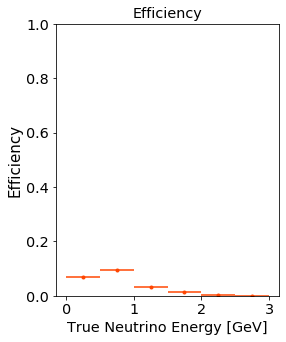

In [10]:

#####Efficiency####
smearing_var1_run1 = pd.read_csv("numu_full_var1_eff_recoCut_"+ending+".csv")

with open('numu_full_weight1_eff_recoCut_'+ending+'.csv', 'r') as read_obj:
        csv_reader = csv.reader(read_obj)
        smearing_weight1_run1 = list(csv_reader)

for a in range(len(smearing_weight1_run1)):
    smearing_weight1_run1[a] = float(smearing_weight1_run1[a][0])
### 
smearing_var2_run1 = pd.read_csv("numu_full_var2_eff_recoCut_"+ending+".csv")

with open('numu_full_weight2_eff_recoCut_'+ending+'.csv', 'r') as read_obj:
        csv_reader = csv.reader(read_obj)
        smearing_weight2_run1 = list(csv_reader)

for a in range(len(smearing_weight2_run1)):
    smearing_weight2_run1[a] = float(smearing_weight2_run1[a][0])
###---####
smearing_var1_run3 = pd.read_csv("numu_full_var1_eff_recoCut_run3_"+ending+".csv")

with open('numu_full_weights1_eff_recoCut_run3_'+ending+'.csv', 'r') as read_obj:
        csv_reader = csv.reader(read_obj)
        smearing_weight1_run3 = list(csv_reader)

for a in range(len(smearing_weight1_run3)):
    smearing_weight1_run3[a] = float(smearing_weight1_run3[a][0])
### 
smearing_var2_run3 = pd.read_csv("numu_full_var2_eff_recoCut_run3_"+ending+".csv")

with open('numu_full_weights2_eff_recoCut_run3_'+ending+'.csv', 'r') as read_obj:
        csv_reader = csv.reader(read_obj)
        smearing_weight2_run3 = list(csv_reader)

for a in range(len(smearing_weight2_run3)):
    smearing_weight2_run3[a] = float(smearing_weight2_run3[a][0])
    
####################Add#####################

var_temps = [smearing_var1_run1, smearing_var1_run3]
var1 = pd.concat(var_temps)
var1 = var1.drop(["entry"], axis=1)
var1 = var1.squeeze()
weight1 = list(smearing_weight1_run1) + list(smearing_weight1_run3)
weight1 = np.array(weight1)

print(type(var1))
print(type(weight1))

var_temps = [smearing_var2_run1, smearing_var2_run3]
var2 = pd.concat(var_temps)
var2 = var2.drop(["entry"], axis=1)
var2 = var2.squeeze()
weight2 = list(smearing_weight2_run1) + list(smearing_weight2_run3)
weight2 = np.array(weight2)


bins = np.arange(0.0, 3.5, 0.5)

variable = 'true_e'
xaxis = "True Neutrino Energy [GeV]"
isCombined = True
if isCombined == True:
    savetitle = "batch_eff_numu_fig_full_500_catsel_nopions_recoE_matrix_trueeff_comb_"+ending+".csv"
    savetitleplot = "batch_eff_numu_fig_full_500_catsel_nopions_recoE_matrix_trueeff_"+ending+".svg"

plot_signal_and_eff(var1, weight1, var2, weight2, bins, variable, xaxis, savetitle, savetitleplot)

In [1]:
#######################OLD###################################

## OLD from here

## Purity and Efficiency

Selection Efficiency = no. reconstructed neutrinos classified as numu CC that pass selection / total number of these simulated in the fiducial volume.

Selection Purity = no. reconstructed neutrinos classified as numu CC that pass selection / total number of selected neutrinos in any classification.

### Smearing Matrix Work

In [39]:
# plot the smearing matrix 
def plot_smearing(selected, signal, true, reco, bins, norm=False): 
    fig = plt.figure(figsize=(10, 6))
    
    smear = plt.hist2d(selected.query(signal)[true],selected.query(signal)[reco],
                   bins, cmin=0.000000001, cmap='OrRd')
    
    zero_copy_smear = np.copy(smear[0].T)
    
    for i in range(len(bins)-1): # reco bins i (y axis) rows
        for j in range(len(bins)-1): # true bins j (x axis) cols
            if np.isnan(zero_copy_smear[i,j]):
                zero_copy_smear[i,j]= 0

    for i in range(len(bins)-1): # reco bins i (y axis) rows
        for j in range(len(bins)-1): # true bins j (x axis) cols
            if smear[0].T[i,j] > 0: 
                if smear[0].T[i,j]>80: 
                    col='white'
                else: 
                    col='black'
                    
                binx_centers = smear[1][j]+(smear[1][j+1]-smear[1][j])/2
                biny_centers = smear[2][i]+(smear[2][i+1]-smear[2][i])/2
                        
                plt.text(binx_centers, biny_centers, round(smear[0].T[i,j], 1), 
                    color=col, ha="center", va="center", fontsize=12)

    cbar = plt.colorbar()
    cbar.set_label('Selected Signal Events', fontsize=15)

    if norm: 
        plt.close()
        
        norm_array = smear[0].T
    
        # for each truth bin (column): 
        for j in range(len(bins)-1): 
        
            reco_events_in_column = [ norm_array[i][j] for i in range(len(bins)-1) ]
            tot_reco_events = np.nansum(reco_events_in_column)
        
            # replace with normalized value 
            for i in range(len(bins)-1): 
                norm_array[i][j] =  norm_array[i][j] / tot_reco_events
    
        # now plot
        fig = plt.figure(figsize=(10, 6))
        plt.pcolor(bins, bins, norm_array, cmap='OrRd', vmax=1)
        
        zero_copy_smear_norm = np.copy(norm_array)

        for i in range(len(bins)-1): # reco bins i (y axis) rows
            for j in range(len(bins)-1): # true bins j (x axis) cols
                if np.isnan(zero_copy_smear_norm[i,j]):
                    zero_copy_smear_norm[i,j]= 0

        print(zero_copy_smear_norm)
    
        # Loop over data dimensions and create text annotations.
        for i in range(len(bins)-1): # reco bins (rows)
            for j in range(len(bins)-1): # truth bins (cols)
                if norm_array[i][j]>0: 
                
                    if norm_array[i][j]>0.7: 
                        col = 'white'
                    else: 
                        col = 'black'
                    
                    binx_centers = smear[1][j]+(smear[1][j+1]-smear[1][j])/2
                    biny_centers = smear[2][i]+(smear[2][i+1]-smear[2][i])/2
                
                    plt.text(binx_centers, biny_centers, round(norm_array[i][j], 2), 
                         ha="center", va="center", color=col, fontsize=12)
      
        cbar = plt.colorbar()
        cbar.set_label('Fraction of Reco Events in True Bin', fontsize=15)
        
        #np.savetxt("numu_full_500_catsel_nopions_recoE_usingSelection_smearcept.csv", 
        #   zero_copy_smear_norm,
        #   delimiter =", ", 
        #   fmt ='% s')

    plt.xlabel('True ν Energy [GeV]', fontsize=15)
    plt.ylabel('Reco ν Energy [GeV]', fontsize=15)
    plt.text(0.1, 4.8, r'MicroBooNE In Progress', fontweight='bold')
    
    plt.show()

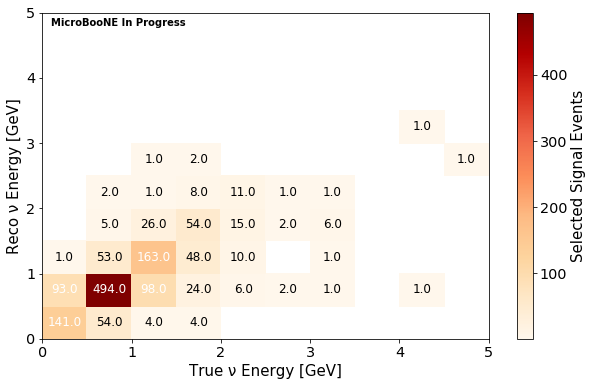

In [40]:
# true nu energy 
true_var = 'nu_e'

# reconstructed nu energy 
reco_var = 'reco_e'

bins = np.arange(0, 5.5, 0.5)

#fiduc_q = "true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 #254.8 and true_nu_vtx_x > -1.55 and ((nu_pdg) == 12 and ccnc == 0) and nproton > 0"

fiduc_q  = "(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5)"
fiduc_q  += " and category == 2"


selected = mc.query(SEL_QUERY)
selected_fid = selected.query(fiduc_q)

# relationship between true & reco values
plot_smearing(selected_fid, fiduc_q, true_var, reco_var, bins)

[[0.6   0.089 0.014 0.029 0.    0.    0.    0.    0.    0.   ]
 [0.396 0.812 0.334 0.171 0.143 0.4   0.111 0.    0.5   0.   ]
 [0.004 0.087 0.556 0.343 0.238 0.    0.111 0.    0.    0.   ]
 [0.    0.008 0.089 0.386 0.357 0.4   0.667 0.    0.    0.   ]
 [0.    0.003 0.003 0.057 0.262 0.2   0.111 0.    0.    0.   ]
 [0.    0.    0.003 0.014 0.    0.    0.    0.    0.    1.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.5   0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]]


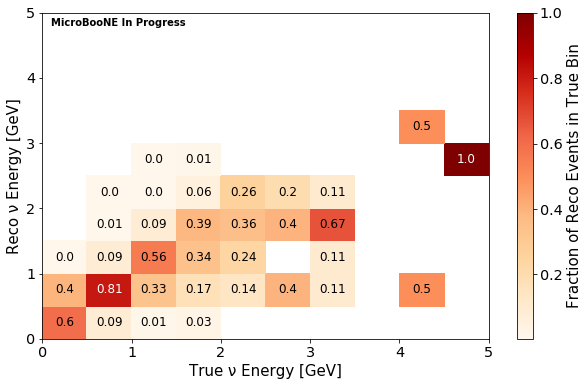

In [41]:
# relationship between true & reco values
plot_smearing(selected_fid, fiduc_q, true_var, reco_var, bins, norm=True)

In [42]:
with open('batch_eff_numu_fig_full_500_catsel_nopions_recoE_matrix.csv') as file:
    content = file.readlines()
effs = content[0:]
    
for i in range(10):
    effs[i]=effs[i].rstrip().rstrip(',')
    effs[i] = float(effs[i])
    
print(effs)
print("")
#----------------------------------------------------------------------------------

with open('numu_full_500_catsel_nopions_recoE_usingSelection_smearcept.csv') as file:
    content = file.readlines()
smear = content[0:]

for i in range(10):
    smear[i]=smear[i].rstrip().rstrip(',')
    smear[i] = [float(idx) for idx in smear[i].split(', ')]
    
print((smear))
print("")

#------------------------------------------------------------------

#print(np.dot(effs, data_signal))
for i in range(10):
    smear[i] = [a*b for a,b in zip(smear[i], effs)]
    
print(smear)
print("")

np.savetxt("numu_full_500_catsel_nopions_recoE_usingSelection_smearcept.csv", 
   smear,
   delimiter =", ", 
   fmt ='% s')

#--------------------------------------------------------

#Now test by multiplying with the prior_true_signal

with open('numu_full_500_catsel_nopions_recoE_usingSelection_prior_true_signal.csv') as file:
    content = file.readlines()
prior_true = content[0:]
    
for i in range(10):
    prior_true[i]=prior_true[i].rstrip().rstrip(',')
    prior_true[i] = float(prior_true[i])
    
print(prior_true)
print("")

made_data_sig = np.dot(smear, prior_true)
print(made_data_sig)
print("")

for i in made_data_sig:
    print(i)

[0.4750760510587767, 0.3366111763807367, 0.14775031337657218, 0.05974603037171938, 0.03389391775518658, 0.01910834236787515, 0.008119696272598143, 0.0071000384159739995, 0.010589988569390038, 0.0]

[[0.6, 0.08881578947368421, 0.013651877133105802, 0.02857142857142857, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.39574468085106385, 0.8125, 0.33447098976109213, 0.17142857142857143, 0.14285714285714285, 0.4, 0.1111111111111111, 0.0, 0.5, 0.0], [0.00425531914893617, 0.08717105263157894, 0.5563139931740614, 0.34285714285714286, 0.23809523809523808, 0.0, 0.1111111111111111, 0.0, 0.0, 0.0], [0.0, 0.008223684210526315, 0.08873720136518772, 0.38571428571428573, 0.35714285714285715, 0.4, 0.6666666666666666, 0.0, 0.0, 0.0], [0.0, 0.003289473684210526, 0.0034129692832764505, 0.05714285714285714, 0.2619047619047619, 0.2, 0.1111111111111111, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0034129692832764505, 0.014285714285714285, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0], [0.0, 0.0, 0.0, 

In [43]:
##------------------------------------------------------------------